# Abstract 

##### La idea de esta notebook es evaluar y poder predecir por cada pais los contagios y las muertes obsercando del data set datos como pueden llegar a ser los casos ya activos el ratio de reproduccion del virus la poblacion de cada pais, el porcetaje de la poblacion que es mayor de edad o factor de riesgo etc, y ver como esto impacta en lo antes mecionado. El data frame tambien cuneta con informacion relevante en cuanto a las instalaciones santirias de los paises como pueden ser las camas diponibles y ocupadas de terapia intesiva, la cantidad de la poblacion con acceso a intalacions basicas de higiene, todo esto lo cual puede llegar a ser relevante al momento de ver el comportamiento del virus en el tiempo.

# Preguntas

##### El dataframe(df de ahora en adelante) proporciona como mencione antes varias instalaciones "sanitarias" que tiene el pais, una de las prguntas que nos podemos hacer en base a esto es ver que tanto influye o influyo que cada pais tenga o no estas instalaciones en el crecimiento o decrecimiento de los casos. 

##### Tambien el df porporcina informacion sobre las vacunaciones, teniendo en cuenta esto podemos ver la influencia de las vacunaciones en los casos nuevos, pero principalmente nos interesa ver que modificacion genero en las nuevas muertes, ya que el objetivo final de la vacuna no es evitar el contagio sino evitar la muerte.

##### Tambien contamos con datos como puede ser el *stringency_index* que es basicamente como el pais responde en base al progreso del virus generando cuarentenas o prohibiendo ciertas avtividades como pueden ser la presencialidad en los colegios, con esta data podemos ver si la "cuarentena" fue realmente efectiva en ciertos casos. 

##### Respondiendo estas y otras preguntas que se generan mas adelante intentaremos predecir no solo los nuevos casos sino tambien las nuevas muertes que se pueden llegar a generar a causa del virus.


In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from   scipy import stats
import statsmodels.formula.api as sm
import chart_studio.plotly     as py
from bokeh.resources import INLINE
import bokeh.io
from bokeh import *
import pingouin
from IPython.display import display
from ipywidgets import Dropdown
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

 ### Carga del dataset con pandas

In [53]:
df = pd.read_csv("..\DataSets\owid-covid-data.csv")
df['Porcentaje_contagios'] = (df['total_cases'] / df['population']) * 100
df.head(5)

## df.columns

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Porcentaje_contagios
0,AFG,Asia,Afghanistan,2/24/2020,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012
1,AFG,Asia,Afghanistan,2/25/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012
2,AFG,Asia,Afghanistan,2/26/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012
3,AFG,Asia,Afghanistan,2/27/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012
4,AFG,Asia,Afghanistan,2/28/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012


Dentro de las colunmas que mas nos interesan estan las siguientes

- *Continent* : continete al cual pertenecen los paises a analizar
- *Location* : nombre del pais 
- *Date* : fecha en la cual se recabaron los datos 
- *total_cases* : acumulado de casos hasta el dia de la fecha 
- *new_cases* : nuevos casos en un dia dado
- *total_death* : muertes acumuladas hasta el dia de la fecha 
- *new_death* : nuevas muertes en un dia dado
- *icu_patients* : cantidad de pacientes en Terapia intesiva en un dia dado 
- *hosp_patients* : catidad de pacientes en hospital en un dia dado 
- *weekly_icu_admissions* : cantidad de ingresados en terapia intesiva en una semana dada
- *weekly_hosp_admissions* : catidad de pacientes ingresados en el hospital en una semana dada
- *stringency_index* : idice de rigurosiad de la respuesta del gobierno(cierre de escuelas, prohibicion de viajes,etc) escalado a un valor en tre 0 y 100 siendo 100 la repuesta mas stricta.
- *reporduction_rate* : ratio de reprodccion del virus 
- *totaL_test* : cantidad acumulada de testeos
- *new_test* :  nuevos testeos realizados en un dia dado
- *positive_rate* : porcentaje de los testeos realizado que resultaron positivos.
- *total_vaccinations* : cantidad total de dosis de vacunacion aplicadas
- *people_vaccionations* : total de personas que recibieron al menos una dosis de la vacuna 
- *people_fully_vaccinated* : cantidad total de personas que recibieron todas las dosis de la vacuna
- *total_booster* :  catidad de refuerzo de vacuna que fueron aplicados
- *new_vaccinations* : catidad nueva de dosis aplicadas en un dia dado
- *population* : ultimo dato disponible de la poblacion de cada pais al momento de la toma de la muestra.
- *population_density* : desidad poblacional
- *handwashing_facilities* : parte de la poblacion que posee intalaciones basicas para higine personal. 



### Ordenamiento de la base de datos 

In [71]:
# copia de la base de datos
copy_df = df.copy()

copy_df['Porcentaje_contagios'] = copy_df['Porcentaje_contagios'].dropna()

#convierto la coluna de fechas al formato de fecha 
copy_df['date'] = pd.to_datetime(copy_df['date'])

# Agrupar por paises continentes y paises
continentes = copy_df.groupby("continent")

# Separo por continente 

copy_df = copy_df.query('continent in ["Europe"]')

paises = copy_df.groupby("location")
#copy_df['date']
paises


###### Selccionamos solo los paises de europa para hacer nuestro analisis solo sobre ellos 

# Grafico de Nuevos casos vs indice de restriccion

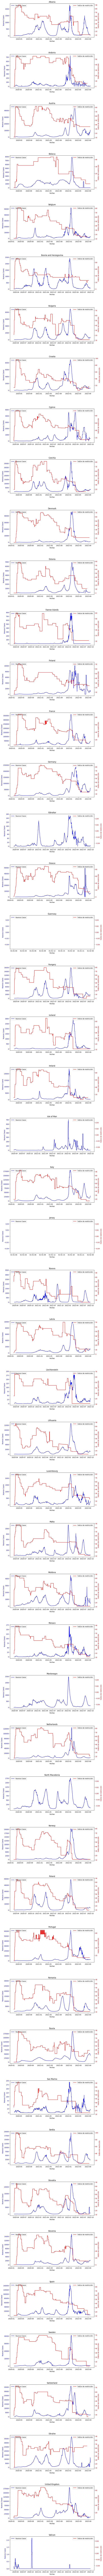

In [41]:
fig, axs = plt.subplots(nrows=len(copy_df['location'].unique()), figsize=(10, 6*len(copy_df['location'].unique())))
plt.subplots_adjust(hspace=0.5)

# Iterar sobre cada país y crear un gráfico separado para cada uno
for i, (pais, grupo) in enumerate(paises):
    ax1 = axs[i]
    ax2 = ax1.twinx()

    # Graficar el primer conjunto de datos (nuevos casos)
    ax1.plot(grupo['date'], grupo['new_cases_smoothed'], color='blue', label='Nuevos Casos')
    # Graficar el segundo conjunto de datos (Índice de restricción)
    ax2.plot(grupo['date'], grupo['stringency_index'], color='red', label='Índice de restricción')
    
    ax1.set_ylabel('Nuevos Casos', color='blue')
    ax2.set_ylabel('Índice de restricción', color='red')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    ax1.set_title(pais)
    ax1.set_xlabel('Fechas')

    # Agregar leyenda y mostrar el gráfico
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.show()

### Analisis de las graficas

Podemos notar en estas graficas que usuamente al bajar el indice de reestriccion en cada pais se pueden notar incrementos en los casos nuevos, con esto a simple vista podemos llegar a intuir que las restricciones aplicadas por pais si dan resultado, pero esta tambien es una primera instacia de analisis quedan muchos datos mas por analizar a lo largo del proyecto.

# Grafico de nuevas muertes por pais 


In [42]:
##for i, (name, group) in enumerate(paises):
##    color = (random.random(), random.random(), random.random());
##    group.plot(x='date', y='total_deaths', label=name, color = color,figsize=(10,6))
##    plt.xlabel('Fecha')
##    plt.ylabel('Cant Muertes')


#plt.legend()
#plt.show()




### Analisis

##### En estos graficos podemos ver las nuevas muertes por dia en cada pais

# Grafico de maximos de testeos por pais 

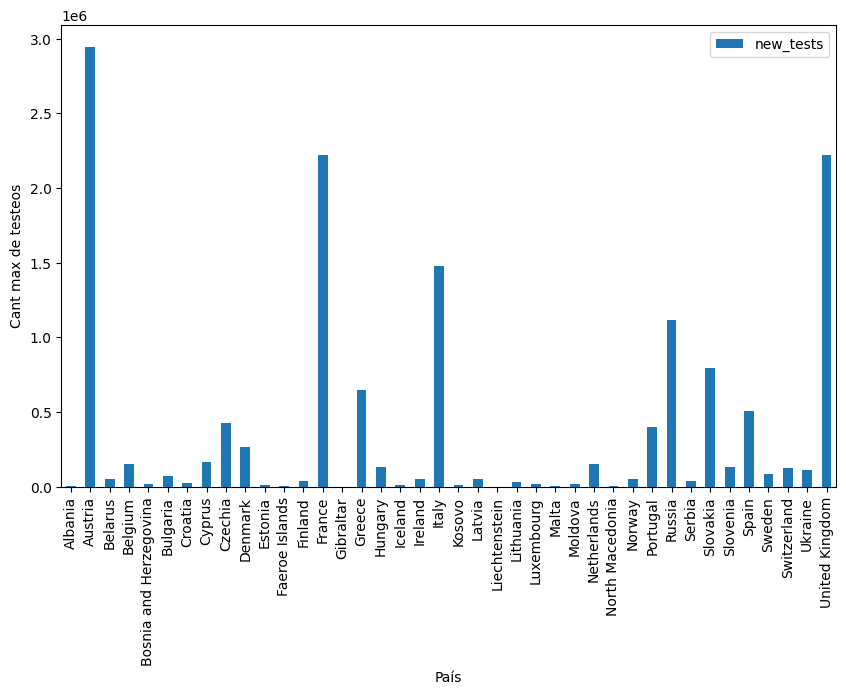

In [43]:

## excluyo los paises que no tiene datos de los nuevos testeos 
df2 = copy_df.dropna(subset=['new_tests'])

df_grouped = df2.groupby('location').max()

df_grouped.plot(kind='bar', y='new_tests',figsize=(10,6))
plt.xlabel('País')
plt.ylabel('Cant max de testeos')

plt.show()

En esta grafica podemos ver el maximo de testeos en un dia por pais en Europa

# Grafico barras de total de vacunados por pais


C:\Users\Ignacio\AppData\Local\Temp\ipykernel_13172\2162397455.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  df_grouped = df3.groupby('location').max()


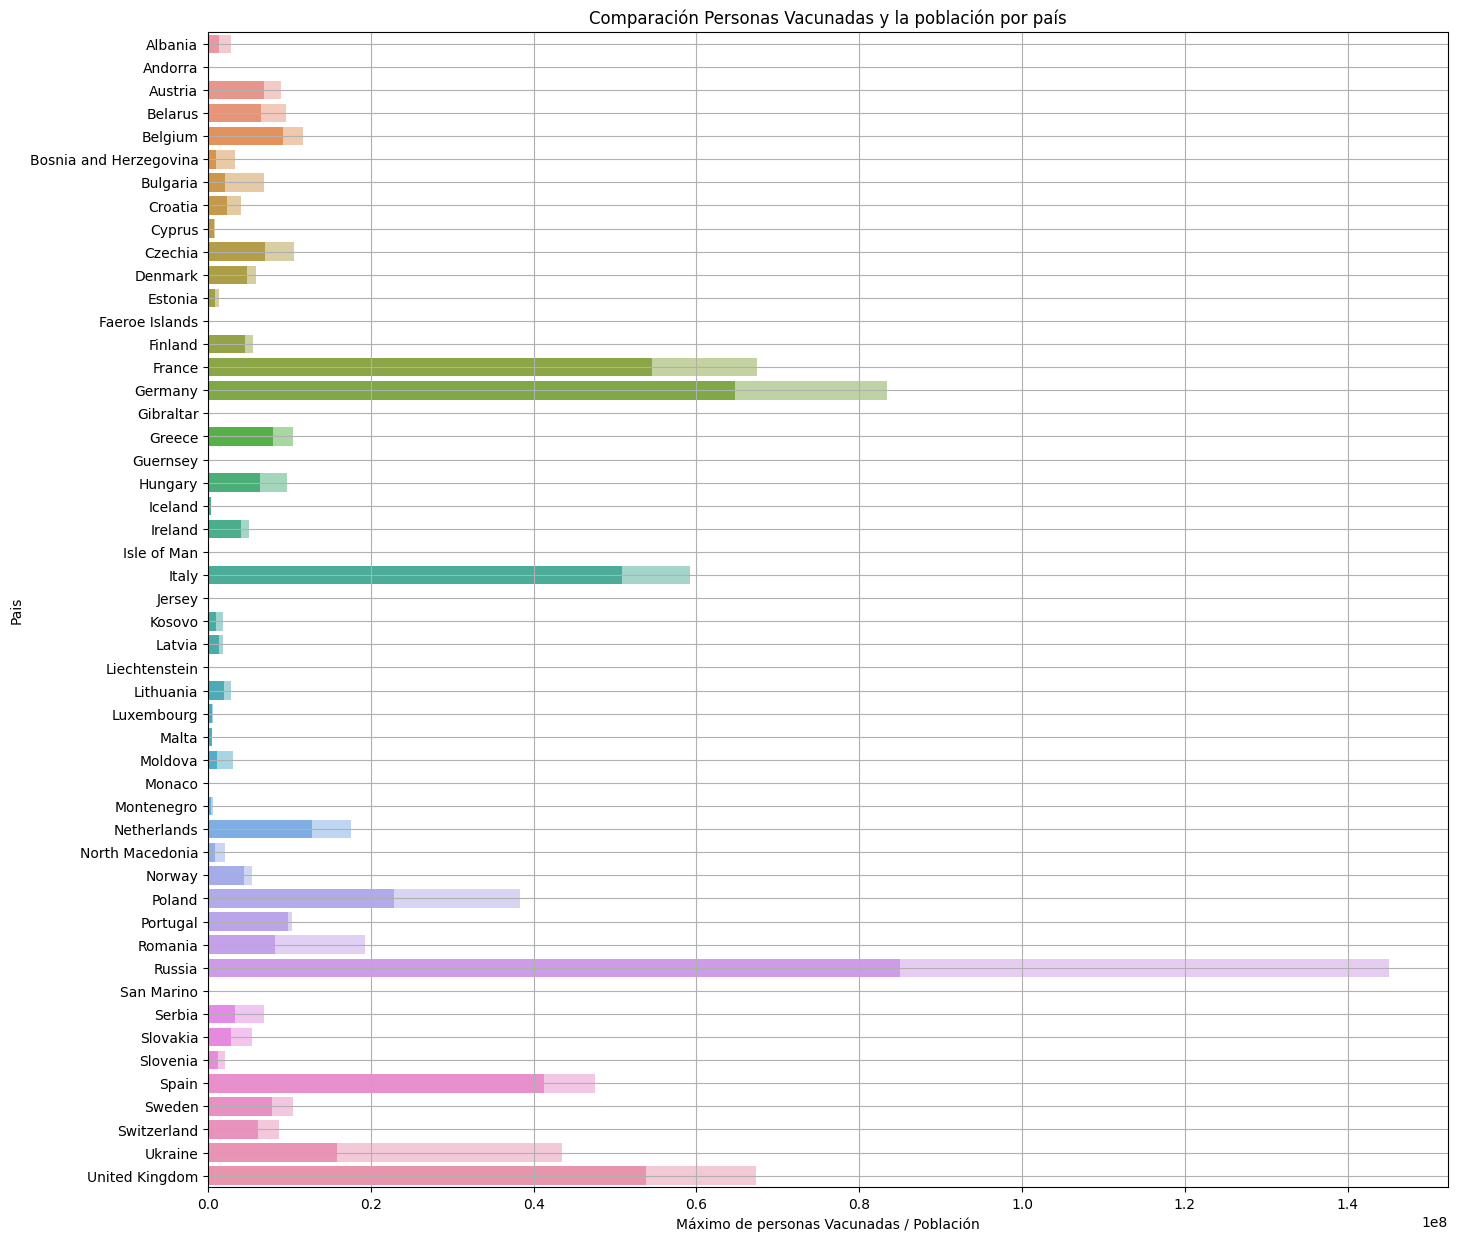

In [44]:
df3 = copy_df.dropna(subset=["people_vaccinated"])

plt.figure(figsize=(16,15))
df_grouped = df3.groupby('location').max()
sns.barplot(y=df_grouped.index, x='population', data=df_grouped,  alpha = 0.5)
sns.barplot(y=df_grouped.index, x='people_vaccinated', data=df_grouped )
plt.grid()
plt.xlabel('Máximo de personas Vacunadas / Población')
plt.ylabel('Pais')
plt.title('Comparación Personas Vacunadas y la población por país')
plt.show()

En este grafico podemos ver la comparativa entre el total de personas vacunadas y el total de la poblacion del los paises.

# Grafico de ingresos al hopital vs ingresos a terapia intesiva

seaborn

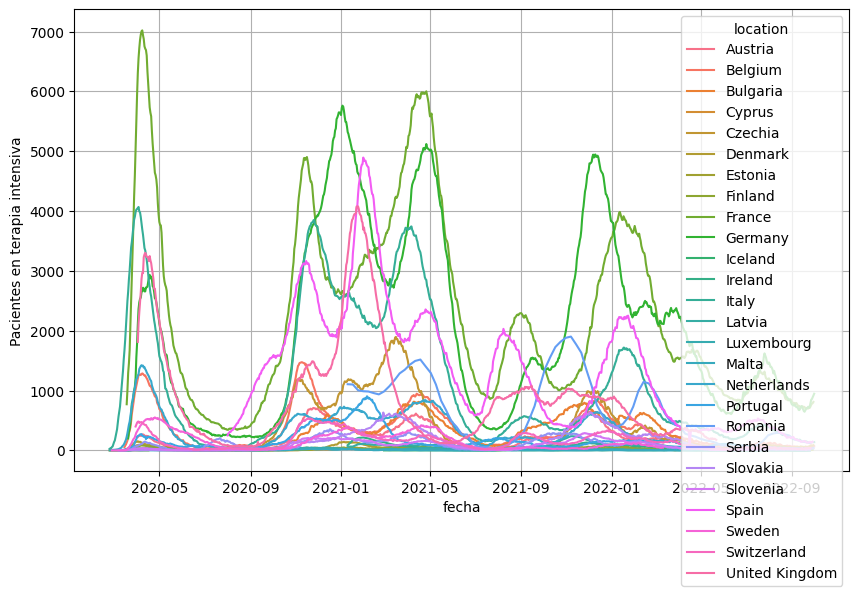

In [45]:
df3 = copy_df.dropna(subset=["icu_patients"])
#df4 = copy_df.dropna(subset=["hosp_patients"])

plt.figure(figsize=(10,6))


#sns.lineplot(x=df4['date'], y='hosp_patients', data=df4,hue='location')
sns.lineplot(x=df3['date'], y='icu_patients', data=df3, hue='location')
plt.grid()
plt.xlabel('fecha')
plt.ylabel('Pacientes en terapia intensiva')
plt.title('')
plt.show()
#df3

Este grafico muestrs por fecha la cantidad de pacientes que ingresaron a la terapia intesiva por pais 

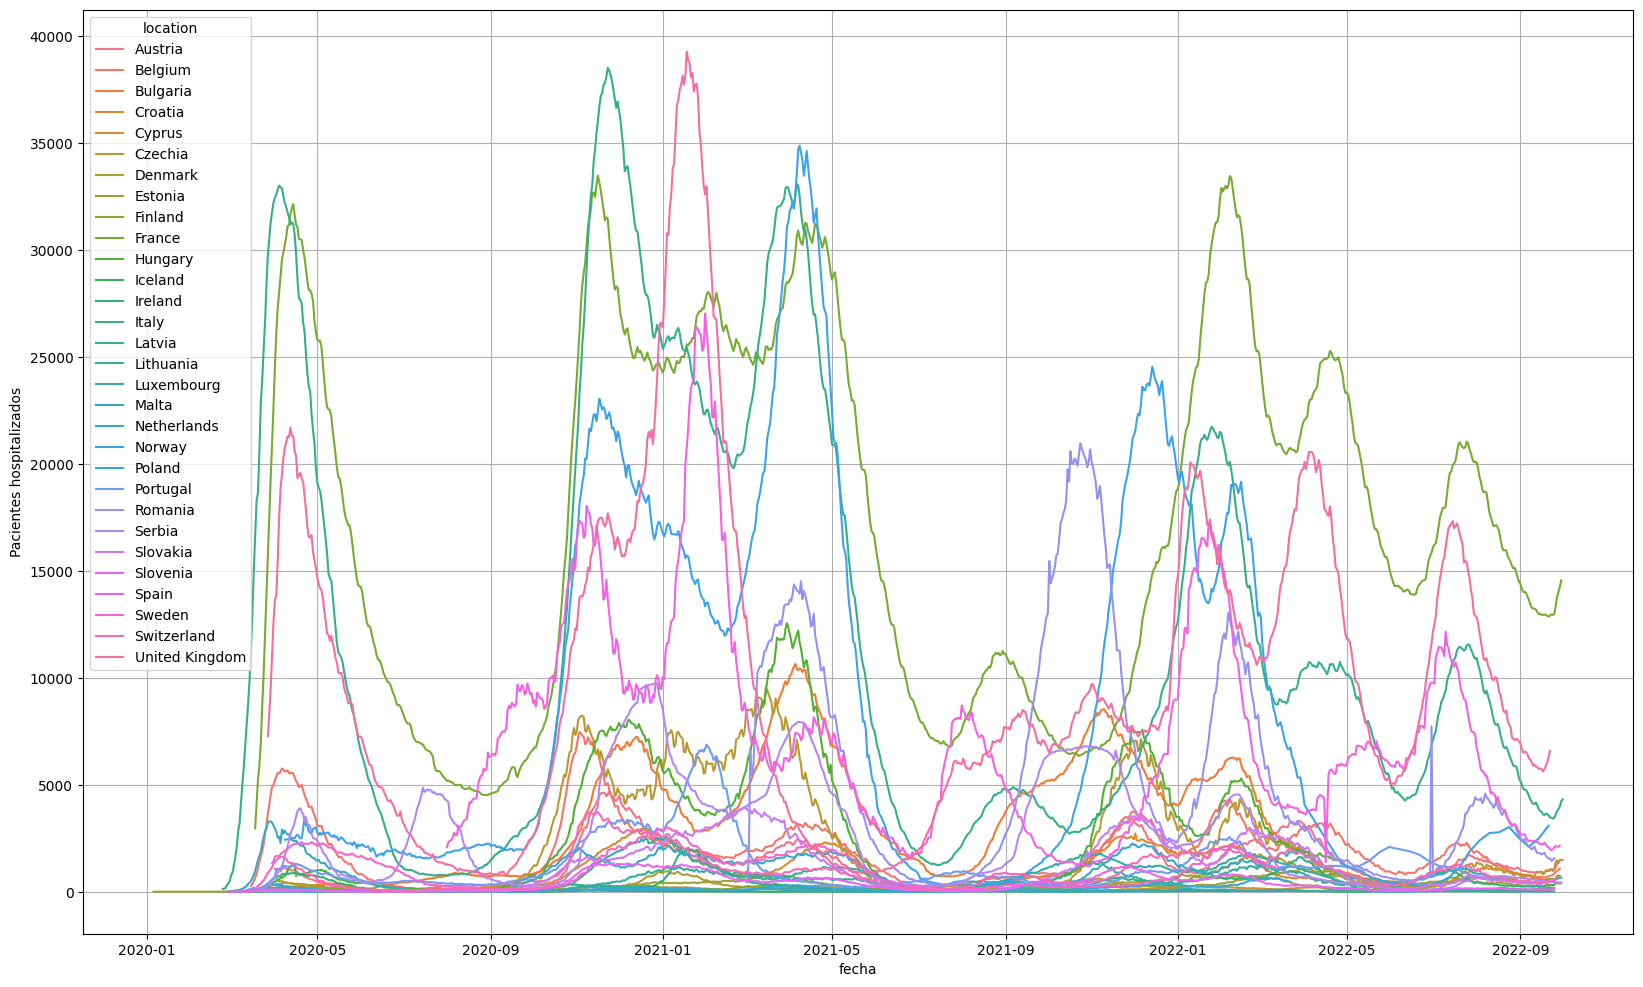

In [46]:
#df3 = copy_df.dropna(subset=["icu_patients"])
df4 = copy_df.dropna(subset=["hosp_patients"])

plt.figure(figsize=(20,12))


sns.lineplot(x=df4['date'], y='hosp_patients', data=df4,hue='location')
#sns.lineplot(x=df3['date'], y='icu_patients', data=df3, hue='location')
plt.grid()
plt.xlabel('fecha')
plt.ylabel('Pacientes hospitalizados')
plt.title('')
plt.show()
#df3

Este grafico es similar al anterior pero muestra las personas que fueron solamente hospitalizadas

# Modelos 


# Modelo para predecir nuevos casos por pais 

In [72]:
# copia de la base de datos
copy_df2 = df.copy()

#convierto la coluna de fechas al formato de fecha 
copy_df2['date'] = pd.to_datetime(copy_df['date'])

# Eliminar valores Nan
copy_df2.replace('NaN',np.nan,inplace= True)

copy_df2.fillna(0,inplace=True)

copy_df2= copy_df.set_index('date')

# Agrupar por continentes
# continentes = copy_df.groupby("continent")

# Separo el contiente europeo que es con el que deseo trabaajar
df_europe = copy_df2.query('continent in ["Europe"]')

df_asia = copy_df2.query('continent in ["Asia"]')

copy_df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [48]:
modelE  = 'new_cases_smoothed~location + population + stringency_index + people_vaccinated  + people_fully_vaccinated  + hosp_patients + total_cases + reproduction_rate + total_tests + new_tests + life_expectancy + human_development_index + handwashing_facilities + gdp_per_capita + extreme_poverty'

lmE = sm.ols(formula=modelE , data= df_europe)

result = lmE.fit()

print(result.summary())

ValueError: zero-size array to reduction operation maximum which has no identity

# Modelo para predecir nuevas muertes por dia 

In [ ]:
model2  = 'new_deaths_smoothed~location + stringency_index  + new_cases + population + people_vaccinated  + people_fully_vaccinated  + hosp_patients + total_cases + reproduction_rate + total_tests + new_tests + life_expectancy + human_development_index + handwashing_facilities + gdp_per_capita + extreme_poverty'

lm2 = sm.ols(formula=model2 , data= df_europe)

result2 = lm2.fit()

print(result2.summary())

                             OLS Regression Results                            
Dep. Variable:     new_deaths_smoothed   R-squared:                       0.644
Model:                             OLS   Adj. R-squared:                  0.643
Method:                  Least Squares   F-statistic:                     1458.
Date:                 Sat, 25 Feb 2023   Prob (F-statistic):               0.00
Time:                         11:15:20   Log-Likelihood:            -2.6907e+05
No. Observations:                47659   AIC:                         5.383e+05
Df Residuals:                    47599   BIC:                         5.388e+05
Df Model:                           59                                         
Covariance Type:             nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------